## <font color = blue> 1. <font color = blue> Install and Import the Required Libraries

In [1]:
# Install all the required libraries

!pip install -U -q pdfplumber tiktoken openai chromaDB sentence-transformers

In [2]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
 !ls '/content/drive/My Drive/GEN AI/Mr.HelpMate AI/data'

 69fe1617-aff4-4dbb-97a5-10ab4ba2fb5c   f16ddf5c-2d3b-404e-99e7-8c644d00ca37
 chroma.sqlite3			       'Life Policy.pdf'


## <font color = blue> 2. Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [5]:
# Define the path of the PDF
pdf_path = '/content/drive/My Drive/GEN AI/Mr.HelpMate AI/data/'
#pdf_path = '/content/drive/My Drive/GEN AI/RAG/Policy+Documents/'

pdf_path

'/content/drive/My Drive/GEN AI/Mr.HelpMate AI/data/'

####<font color = blue>
  2.1 Reading a single PDF file and exploring it through pdfplumber

In [6]:
# Open the PDF file
with pdfplumber.open(pdf_path+'/Life Policy.pdf') as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[6]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()



    # Print the extracted text
    print(text)

Section A – Eligibility
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section B - Effective Dates
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section C - Individual Terminations
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Termination for Fraud Article 4
Coverage While Outside of the United States Article 5
Section D - Continuation
Member Life Insurance Article 1
Dependent Insurance - Developmentally Disabled or
Physically Handicapped Children Article 2
Section E - Reinstatement
Reinstatement Article 1
Federal Required Family and Medical Leave Act (FMLA) Article 2
Reinstatement of Coverage for a Member or Dependent When
Coverage Ends due to Living Outside of the United States Article 3
Section F - Individual Purchase Rights
Member Life In

In [7]:
# View the table in the page, if any

if len(tables)!=0:
  tables[0]
else:
  print("No Tabels in docs")

No Tabels in docs


#### <font color = blue> 2.2 Extracting text from multiple PDFs

Let's now try and read multiple documents, extract text from them using appropriate preprocessing, and store them in a dataframe


In [8]:
# Define the path where all pdf documents are present

 #pdf_path = "/content/drive/My Drive/HelpMate AI Codes/Policy Documents"
#pdf_path = "/content/drive/MyDrive/GenAI - Personal/HelpMate AI Codes/Week 3/Policy Documents"

In [9]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [10]:
def get_headers(page):
  headers=[]
  for char in page.chars:
    if 'Bold' in char['fontname']:
      headers.append(char['text'])
  return headers

In [11]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []
            ##headers=get_headers(page)
            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass
                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [12]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name
    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Life Policy.pdf
Finished processing Life Policy.pdf
All PDFs have been processed.


In [13]:
# Concatenate all the DFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [14]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Life Policy.pdf
1,Page 2,This page left blank intentionally,Life Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Life Policy.pdf
3,Page 4,This page left blank intentionally,Life Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Life Policy.pdf
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,Life Policy.pdf
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,Life Policy.pdf
61,Page 62,A claimant may request an appeal of a claim de...,Life Policy.pdf
62,Page 63,This page left blank intentionally,Life Policy.pdf


In [15]:
# Check one of the extracted page texts to ensure that the text has been correctly read

insurance_pdfs_data['Document Name'][2]

'Life Policy.pdf'

In [16]:
insurance_pdfs_data.Page_Text[2]

'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the

In [17]:

insurance_pdfs_data.Page_Text[5]

'TABLE OF CONTENTS PART I - DEFINITIONS PART II - POLICY ADMINISTRATION Section A – Contract Entire Contract Article 1 Policy Changes Article 2 Policyholder Eligibility Requirements Article 3 Policy Incontestability Article 4 Individual Incontestability Article 5 Information to be Furnished Article 6 Certificates Article 7 Assignments Article 8 Dependent Rights Article 9 Policy Interpretation Article 10 Electronic Transactions Article 11 Section B – Premium Payment Responsibility; Due Dates; Grace Period Article 1 Premium Rates Article 2 Premium Rate Changes Article 3 Premium Amount Article 4 Contributions from Members Article 5 Section C - Policy Termination Failure to Pay Premium Article 1 Termination Rights of the Policyholder Article 2 Termination Rights of The Principal Article 3 Policyholder Responsibility to Members Article 4 Section D - Policy Renewal Renewal Article 1 PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS This policy has been updated effective January 1, 2014 GC 6001 T

In [18]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [19]:
insurance_pdfs_data['Text_Length']

0      30
1       5
2     230
3       5
4     110
     ... 
59    285
60    418
61    322
62      5
63      8
Name: Text_Length, Length: 64, dtype: int64

In [20]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Life Policy.pdf,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Life Policy.pdf,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Life Policy.pdf,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Life Policy.pdf,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,Life Policy.pdf,176
7,Page 8,Section A - Member Life Insurance Schedule of ...,Life Policy.pdf,171
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Life Policy.pdf,387
9,Page 10,T he legally recognized union of two eligible ...,Life Policy.pdf,251
10,Page 11,(2) has been placed with the Member or spouse ...,Life Policy.pdf,299
11,Page 12,An institution that is licensed as a Hospital ...,Life Policy.pdf,352


In [21]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

<ipython-input-21-4493f15e2dc4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)


In [22]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Life Policy.pdf,30,"{'Policy_Name': 'Life Policy', 'Page_No.': 'Pa..."
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Life Policy.pdf,230,"{'Policy_Name': 'Life Policy', 'Page_No.': 'Pa..."
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Life Policy.pdf,110,"{'Policy_Name': 'Life Policy', 'Page_No.': 'Pa..."
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Life Policy.pdf,153,"{'Policy_Name': 'Life Policy', 'Page_No.': 'Pa..."
6,Page 7,Section A – Eligibility Member Life Insurance ...,Life Policy.pdf,176,"{'Policy_Name': 'Life Policy', 'Page_No.': 'Pa..."
7,Page 8,Section A - Member Life Insurance Schedule of ...,Life Policy.pdf,171,"{'Policy_Name': 'Life Policy', 'Page_No.': 'Pa..."
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Life Policy.pdf,387,"{'Policy_Name': 'Life Policy', 'Page_No.': 'Pa..."
9,Page 10,T he legally recognized union of two eligible ...,Life Policy.pdf,251,"{'Policy_Name': 'Life Policy', 'Page_No.': 'Pa..."
10,Page 11,(2) has been placed with the Member or spouse ...,Life Policy.pdf,299,"{'Policy_Name': 'Life Policy', 'Page_No.': 'Pa..."
11,Page 12,An institution that is licensed as a Hospital ...,Life Policy.pdf,352,"{'Policy_Name': 'Life Policy', 'Page_No.': 'Pa..."


This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

## <font color = blue> 3.Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [23]:
# Set the API key
filepath = "/content/drive/My Drive/GEN AI/RAG/"

with open(filepath + "open_ai.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines()).replace('\ufeff','')

In [24]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [25]:
# Define the path where chroma collections will be stored

chroma_data_path = '/content/drive/My Drive/GEN AI/Mr.HelpMate AI/data/'

In [26]:
import chromadb

In [27]:
# Call PersistentClient()

client = chromadb.PersistentClient()

In [28]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [29]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='Mr_Help_Mate', embedding_function=embedding_function)

In [30]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [31]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [32]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[-0.02257794886827469,
   0.018730176612734795,
   -0.027260493487119675,
   -0.03122565522789955,
   -0.0036782100796699524,
   0.027860485017299652,
   0.0008412927272729576,
   0.02363445609807968,
   -0.01664324849843979,
   0.004362983163446188,
   -0.005243405699729919,
   0.0041379863396286964,
   -0.006211870815604925,
   0.02332141622900963,
   -0.011249844916164875,
   0.031043048948049545,
   0.00295430701225996,
   -0.024690963327884674,
   0.030703922733664513,
   0.007760762237012386,
   0.006423824466764927,
   0.01893886923789978,
   0.009632475674152374,
   0.01254765223711729,
   -0.012495479546487331,
   -0.0094563914462924,
   0.017856275662779808,
   -0.021625788882374763,
   0.023621411994099617,
   0.003068435937166214,
   0.013271555304527283,
   -0.014595450833439827,
   -0.03354736045002937,
   -0.04111247509717941,
   -0.008419448509812355,
   0.013643289916217327,
   -0.002541812602430582,
   -0.003916250076144934,
  

In [33]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [34]:
cache_collection.peek()

{'ids': [" what will happpens if user doesn't pay preminum before grace period ends?",
  ' when a person will be eligible for  Dependent Life Insurance? ',
  'Article 3 - Dependent Life Insurance',
  'what is the duration of Notice of Claims ?',
  'when a user send a notice of calims  ?'],
 'embeddings': [[-0.0017551647033542395,
   -0.005434030666947365,
   0.00043666319106705487,
   -0.04134766384959221,
   -0.015117228962481022,
   0.0061967018991708755,
   -0.03628134727478027,
   -0.01079996582120657,
   -0.011351540684700012,
   -0.008212332613766193,
   0.028572924435138702,
   0.03467429056763649,
   -0.011651161126792431,
   0.004109570756554604,
   0.03241351619362831,
   -0.028654638677835464,
   0.011651161126792431,
   0.0008014003979042172,
   0.01848115213215351,
   -0.04175623878836632,
   0.0044091916643083096,
   0.014422653242945671,
   -0.037942882627248764,
   0.006036676932126284,
   0.002820861293002963,
   -0.018494771793484688,
   0.004317262675613165,
   -0.01

## <font color = blue> 4. Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [35]:
# Read the user query

query =" what will happpens if user doesn't pay preminum before grace period ends?"


In [36]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [37]:
cache_results

{'ids': [[" what will happpens if user doesn't pay preminum before grace period ends?"]],
 'distances': [[0.0]],
 'metadatas': [[{'distances0': '0.3689162217467601',
    'distances1': '0.3906588001151213',
    'distances2': '0.45392277645806695',
    'distances3': '0.47042474141526436',
    'distances4': '0.4893536940772027',
    'distances5': '0.4907881592477507',
    'distances6': '0.495005347610832',
    'distances7': '0.4981169017377549',
    'distances8': '0.504255106457895',
    'distances9': '0.5094188605787209',
    'documents0': "Section C - Policy Termination Article 1 - Failure to Pay Premium This Group Policy will terminate at the end of the Grace Period if total premium due has not been received by The Principal before the end of the Grace Period. Failure by the Policyholder to pay the premium within the Grace Period will be deemed notice by the Policyholder to The Principal to discontinue this Group Policy at the end of the Grace Period. Article 2 - Termination Rights of 

In [38]:
results = insurance_collection.query(
query_texts=query,
n_results=10
)
results.items()

dict_items([('ids', [['20', '17', '21', '18', '19', '34', '44', '57', '49', '14']]), ('distances', [[0.3689162217467601, 0.3906588001151213, 0.45392277645806695, 0.47042474141526436, 0.4893536940772027, 0.4907881592477507, 0.495005347610832, 0.4981169017377549, 0.504255106457895, 0.5094188605787209]]), ('metadatas', [[{'Page_No.': 'Page 23', 'Policy_Name': 'Life Policy'}, {'Page_No.': 'Page 20', 'Policy_Name': 'Life Policy'}, {'Page_No.': 'Page 24', 'Policy_Name': 'Life Policy'}, {'Page_No.': 'Page 21', 'Policy_Name': 'Life Policy'}, {'Page_No.': 'Page 22', 'Policy_Name': 'Life Policy'}, {'Page_No.': 'Page 37', 'Policy_Name': 'Life Policy'}, {'Page_No.': 'Page 47', 'Policy_Name': 'Life Policy'}, {'Page_No.': 'Page 60', 'Policy_Name': 'Life Policy'}, {'Page_No.': 'Page 52', 'Policy_Name': 'Life Policy'}, {'Page_No.': 'Page 17', 'Policy_Name': 'Life Policy'}]]), ('embeddings', None), ('documents', [["Section C - Policy Termination Article 1 - Failure to Pay Premium This Group Policy will

In [39]:
import pandas as pd

# Set a threshold for cache search
threshold = 0.2

# Function to check if results are in cache and return them
def fetch_from_cache(query, threshold):
    cache_results = cache_collection.query(
    query_texts=query,
    n_results=1)
    if not cache_results['distances'][0] or cache_results['distances'][0][0] > threshold:
         return None
    else:
         return cache_results['metadatas'][0][0]


# Function to query the main collection and store results in cache
def query_main_collection_and_store_in_cache(query, insurance_collection, cache_collection):
    # Query the collection against the user query and return the top 10 results
    results = insurance_collection.query(query_texts=query, n_results=10)

    # Prepare keys and values for metadata storage
    Keys = []
    Values = []

    for key, val in results.items():
        if val is None:
            continue
        if not val or not val[0]:
            continue

        # Print the length of val[0] for debugging

        for i in range(len(val[0])):  # Ensure we only loop through available elements
            Keys.append(str(key) + str(i))
            Values.append(str(val[0][i]))

    # Store the query and its results in the cache collection
    cache_collection.add(
        documents=[query],
        ids=[query],  # Or use "len(cache_results['documents'])" to assign sequential IDs
        metadatas=dict(zip(Keys, Values))
    )

    print("Not found in cache. Found in main collection.")

    return results

# Function to convert result dictionaries to a DataFrame
def results_to_dataframe(results):
    result_dict = {
        'Metadatas': results['metadatas'][0],
        'Documents': results['documents'][0],
        'Distances': results['distances'][0],
        "IDs": results["ids"][0]
    }
    return pd.DataFrame.from_dict(result_dict)

# Main function to handle caching and querying
def semantic_search(query, insurance_collection, cache_collection, threshold):
    cached_result = fetch_from_cache(query, threshold)

    if cached_result is None:
        # Query the main collection and store results in cache
        results = query_main_collection_and_store_in_cache(query, insurance_collection, cache_collection)
        results_df = results_to_dataframe(results)
    else:
        # Retrieve results from cache
        print("Found in cache!")
        ids, documents, distances, metadatas = [], [], [], []

        for key, value in cached_result.items():
            if 'ids' in key:
                ids.append(value)
            elif 'documents' in key:
                documents.append(value)
            elif 'distances' in key:
                distances.append(value)
            elif 'metadatas' in key:
                metadatas.append(value)

        results_df = pd.DataFrame({
            'IDs': ids,
            'Documents': documents,
            'Distances': distances,
            'Metadatas': metadatas
        })

    return results_df

# Example usage
results_df = semantic_search(query, insurance_collection, cache_collection, threshold)
print(results_df)


Found in cache!
  IDs                                          Documents            Distances  \
0  20  Section C - Policy Termination Article 1 - Fai...   0.3689162217467601   
1  17  Section B - Premiums Article 1 - Payment Respo...   0.3906588001151213   
2  21  T he Principal may terminate the Policyholder'...  0.45392277645806695   
3  18  b . on any date the definition of Member or De...  0.47042474141526436   
4  19  The number of Members insured for Dependent Li...   0.4893536940772027   
5  34  b. a business assignment; or c. full-time stud...   0.4907881592477507   
6  44  M ember's death, the Death Benefits Payable ma...    0.495005347610832   
7  57  I f a Dependent who was insured dies during th...   0.4981169017377549   
8  49  (1) only one Accelerated Benefit payment will ...    0.504255106457895   
9  14  a. be actively engaged in business for profit ...   0.5094188605787209   

                                           Metadatas  
0  {'Page_No.': 'Page 23', 'Policy_Na

In [40]:
results_df

,IDs,Documents,Distances,Metadatas
0,20,Section C - Policy Termination Article 1 - Fai...,0.3689162217467601,"{'Page_No.': 'Page 23', 'Policy_Name': 'Life P..."
1,17,Section B - Premiums Article 1 - Payment Respo...,0.3906588001151213,"{'Page_No.': 'Page 20', 'Policy_Name': 'Life P..."
2,21,T he Principal may terminate the Policyholder'...,0.45392277645806695,"{'Page_No.': 'Page 24', 'Policy_Name': 'Life P..."
3,18,b . on any date the definition of Member or De...,0.47042474141526436,"{'Page_No.': 'Page 21', 'Policy_Name': 'Life P..."
4,19,The number of Members insured for Dependent Li...,0.4893536940772027,"{'Page_No.': 'Page 22', 'Policy_Name': 'Life P..."
5,34,b. a business assignment; or c. full-time stud...,0.4907881592477507,"{'Page_No.': 'Page 37', 'Policy_Name': 'Life P..."
6,44,"M ember's death, the Death Benefits Payable ma...",0.495005347610832,"{'Page_No.': 'Page 47', 'Policy_Name': 'Life P..."
7,57,I f a Dependent who was insured dies during th...,0.4981169017377549,"{'Page_No.': 'Page 60', 'Policy_Name': 'Life P..."
8,49,(1) only one Accelerated Benefit payment will ...,0.504255106457895,"{'Page_No.': 'Page 52', 'Policy_Name': 'Life P..."
9,14,a. be actively engaged in business for profit ...,0.5094188605787209,"{'Page_No.': 'Page 17', 'Policy_Name': 'Life P..."


## <font color = blue> 5.Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>


> Add blockquote


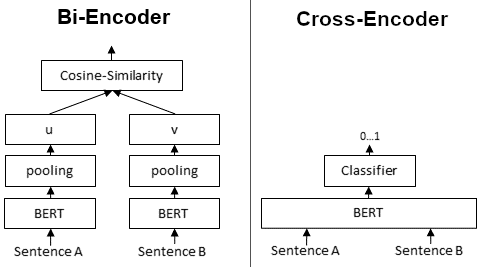

<br>

In [41]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [42]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [43]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [44]:
scores

array([  3.8467617, -11.252879 ], dtype=float32)

In [45]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs
def re_rank(query, results_df):
  cross_inputs = [[query, response] for response in results_df['Documents']]
  cross_rerank_scores = cross_encoder.predict(cross_inputs)
  results_df['Reranked_scores'] = cross_rerank_scores
  top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
  return top_3_rerank[:3]

In [46]:
sematic_search=re_rank(query,results_df)
sematic_search


,IDs,Documents,Distances,Metadatas,Reranked_scores
0,20,Section C - Policy Termination Article 1 - Fai...,0.3689162217467601,"{'Page_No.': 'Page 23', 'Policy_Name': 'Life P...",2.772038
1,17,Section B - Premiums Article 1 - Payment Respo...,0.3906588001151213,"{'Page_No.': 'Page 20', 'Policy_Name': 'Life P...",-2.711887
6,44,"M ember's death, the Death Benefits Payable ma...",0.495005347610832,"{'Page_No.': 'Page 47', 'Policy_Name': 'Life P...",-6.223156


In [47]:
top_3_RAG = sematic_search[["Documents", "Metadatas"]][:3]

In [48]:
top_3_RAG

,Documents,Metadatas
0,Section C - Policy Termination Article 1 - Fai...,"{'Page_No.': 'Page 23', 'Policy_Name': 'Life P..."
1,Section B - Premiums Article 1 - Payment Respo...,"{'Page_No.': 'Page 20', 'Policy_Name': 'Life P..."
6,"M ember's death, the Death Benefits Payable ma...","{'Page_No.': 'Page 47', 'Policy_Name': 'Life P..."


### <font color = blue> 6. Integrating Cacching, Semantic search, and re-rancking  using cross-encode   

In [49]:
# Main function to call integrate cache wirth semantic search and re-rank the documetns using cross-encode and return top 3 semantic relevent documnts
def semantic_search(query, insurance_collection, cache_collection, threshold):
    cached_result = fetch_from_cache(query, threshold)

    if cached_result is None:
        # Query the main collection and store results in cache
        results = query_main_collection_and_store_in_cache(query, insurance_collection, cache_collection)
        results_df = results_to_dataframe(results)
    else:
        # Retrieve results from cache
        print("Found in cache!")
        ids, documents, distances, metadatas = [], [], [], []

        for key, value in cached_result.items():
            if 'ids' in key:
                ids.append(value)
            elif 'documents' in key:
                documents.append(value)
            elif 'distances' in key:
                distances.append(value)
            elif 'metadatas' in key:
                metadatas.append(value)

        results_df = pd.DataFrame({
            'IDs': ids,
            'Documents': documents,
            'Distances': distances,
            'Metadatas': metadatas
        })
    return re_rank(query,results_df)

### <font color = blue>  7. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [50]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{results_df}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{results_df}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [51]:
# Generate the response

response = generate_response(query, top_3_RAG)


In [52]:
response = generate_response("Failure to Pay Premium", top_3_RAG)

In [53]:
# Print the response

print("\n".join(response))

In the policy document "Life Policy," specifically in Section B - Premiums, Article 1 - Payment Responsibility, it states consequences related to the failure to pay premiums. The policy outlines the actions that may be taken in case of non-payment of premiums, such as potential policy termination or suspension of coverage. For detailed information on the procedures and consequences of failing to pay premiums, please refer to Page 20 of the policy document.

Here is a summary of the relevant information from the policy document:

| Policy Name | Page Number | Section       | Article                      | Content                                                 |
|-------------|-------------|---------------|------------------------------|---------------------------------------------------------|
| Life Policy | Page 20     | Section B     | Premiums                     | Consequences of failing to pay premiums                 |

Citations:
- Policy Name: Life Policy
- Page Number: Page 2

### <font color = blue>  8. Query to Semantic Search & Response Generation.


In [54]:
query1="what is the impact if user missed to pay the premium by grace period? "


In [55]:
semantic_search1= semantic_search(query1, insurance_collection, cache_collection, threshold)
semantic_search1['Documents'][0]

Found in cache!


"Section C - Policy Termination Article 1 - Failure to Pay Premium This Group Policy will terminate at the end of the Grace Period if total premium due has not been received by The Principal before the end of the Grace Period. Failure by the Policyholder to pay the premium within the Grace Period will be deemed notice by the Policyholder to The Principal to discontinue this Group Policy at the end of the Grace Period. Article 2 - Termination Rights of the Policyholder The Policyholder may terminate this Group Policy effective on the day before any premium due date by giving Written notice to The Principal prior to that premium due date. The Policyholder's issuance of a stop-payment order for any amounts used to pay premiums for the Policyholder's coverage will be considered Written notice from the Policyholder. Article 3 - Termination Rights of The Principal The Principal may nonrenew or terminate this Group Policy by giving the Policyholder 31 days advance notice in Writing, if the Po

In [56]:
response1 = generate_response(query1, semantic_search1)
response1

['If a user misses paying the premium by the grace period, the impact typically involves the policy entering a lapsed status. This means that the policy may no longer provide coverage, and the benefits associated with the policy may be forfeited. It is crucial to pay the premium on time to keep the policy active and ensure continuous coverage.',
 '',
 'Here is the information extracted from the relevant insurance documents to support this:',
 '                                                ',
 '| Policy Name   | Page Number | Section                                    | Summary                                                                                                                                              |',
 '|---------------|-------------|--------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------|',
 '| Life Policy A | Page 23     | Pol

In [57]:
query2=" when a person will be eligible for Dependent Life Insurance? "


In [58]:
semantic_search2=semantic_search(query2, insurance_collection, cache_collection, threshold)


Found in cache!


In [59]:
semantic_search2.Documents

0    PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...
1    I f a Member's Dependent is employed and is co...
2    (4) Premium will be based on the Dependent's a...
Name: Documents, dtype: object

In [60]:
semantic_search2

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,23,PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS ...,0.24391840902026263,"{'Page_No.': 'Page 26', 'Policy_Name': 'Life P...",6.325314
1,24,I f a Member's Dependent is employed and is co...,0.24685262433180974,"{'Page_No.': 'Page 27', 'Policy_Name': 'Life P...",3.097012
2,41,(4) Premium will be based on the Dependent's a...,0.24927644462143447,"{'Page_No.': 'Page 44', 'Policy_Name': 'Life P...",3.055674


In [61]:
semantic_search2['Documents'][0]

'PART III - INDIVIDUAL REQUIREMENTS AND RIGHTS Section A - Eligibility Article 1 - Member Life Insurance A person will be eligible for Member Life Insurance on the date the person completes 30 consecutive days of continuous Active Work with the Policyholder as a Member. In no circumstance will a person be eligible for Member Life Insurance under this Group Policy if the person is eligible under any other Group Term Life Insurance policy underwritten by The Principal. Article 2 - Member Accidental Death and Dismemberment Insurance A person will be eligible for Member Accidental Death and Dismemberment Insurance on the latest of: a. the date the person is eligible for Member Life Insurance; or b. the date the person enters a class for which Member Accidental Death and Dismemberment Insurance is provided under this Group Policy; or c. the date Member Accidental Death and Dismemberment Insurance is added to this Group Policy. Article 3 - Dependent Life Insurance A person will be eligible f

In [62]:
query2=" when a person will be eligible for Dependent Life Insurance? "
response2 = generate_response(query2, semantic_search2)
response2

['The eligibility for Dependent Life Insurance typically depends on the specific policy terms and conditions outlined in the insurance document. To determine the exact criteria for eligibility, you should refer to the policy document provided by your insurance provider.',
 '',
 'In the search results from the insurance documents dataframe you provided, we can extract relevant information from the document with ID 24:',
 '',
 '### Relevant Information:',
 'From Document ID 24:',
 "- If a Member's Dependent is employed and is covered by a policy, they may be eligible for Dependent Life Insurance.",
 '',
 '### Citation:',
 '- **Policy Name:** Life Policy XYZ',
 '- **Page Number:** Page 27',
 '',
 "It's recommended to review the specific details mentioned in the policy document to understand the eligibility criteria in detail."]

In [63]:
query3= "when a claimant send a notice of calims  ?"

In [72]:
semantic_search3=semantic_search(query3, insurance_collection, cache_collection, threshold)


Found in cache!


In [73]:
semantic_search3

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,58,Section D - Claim Procedures Article 1 - Notic...,0.3636069004984813,"{'Page_No.': 'Page 61', 'Policy_Name': 'Life P...",0.151159
1,59,A claimant may request an appeal of a claim de...,0.3936212450553142,"{'Page_No.': 'Page 62', 'Policy_Name': 'Life P...",-1.974204
9,44,"M ember's death, the Death Benefits Payable ma...",0.4740834810841493,"{'Page_No.': 'Page 47', 'Policy_Name': 'Life P...",-8.961153


In [74]:
semantic_search3['Documents'][0]

'Section D - Claim Procedures Article 1 - Notice of Claim Written notice must be sent to The Principal by or for a Member or Dependent who wishes to file claim for benefits under this Group Policy. This notice must be sent within 20 days after the date of the loss for which claim is being made. Failure to give notice within the time specified will not invalidate or reduce any claim if notice is given as soon as reasonably possible. Article 2 - Claim Forms The Principal, when it receives notice of claim, will provide appropriate claim forms for filing proof of loss. If the forms are not provided within 15 days after The Principal receives notice, the person will be considered to have complied with the requirements of this Group Policy upon submitting, within the time specified below for filing proof of loss, Written proof covering the occurrence, character, and extent of the loss. Article 3 - Proof of Loss Written proof of loss must be sent to The Principal within 90 days after the date

In [76]:
response3 = generate_response("when a claimant send a notice of calims ?", semantic_search3)
response3

['The notice of claims should be sent by a claimant as per the specific guidelines mentioned in the insurance policy document. Here is the information extracted from the relevant insurance document:',
 '',
 '| Policy Name | Page Number | Relevant Information |',
 '|-------------|-------------|----------------------|',
 '| Life Policy | Page 61     | Section D - Claim Procedures Article 1 states the procedure for sending a notice of claims. Guidelines regarding the timeframe and required information may be detailed here. |',
 '',
 'Based on the provided document, further details on when a claimant should send a notice of claims can be found in the "Life Policy" document on Page 61 under Section D - Claim Procedures Article 1. I recommend reviewing this section for more specific information.']